# 1. Loading Dataset from Hugging Face

In [3]:
from datasets import load_dataset
languages = ["en", "fr", "de", "hi", "te", "ta", "pa", "mr", "bn", "ru"]

datasets = []

min_samples = float('inf')

for lang in languages:
    print(lang + " language is downloading")
    ds = load_dataset("wikimedia/wikipedia", "20231101." + lang)["train"]

    row_count = len(ds)
    print(lang + " dataset has " + str(row_count) + " rows")

    min_samples = min(min_samples, row_count)
    datasets.append(ds)  

print("\nSmallest dataset has " + str(min_samples) + " rows, we will balance according to this")

en language is downloading


Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/41 [00:00<?, ?it/s]

en dataset has 6407814 rows
fr language is downloading


Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

fr dataset has 2564646 rows
de language is downloading


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

de dataset has 2845308 rows
hi language is downloading
hi dataset has 163093 rows
te language is downloading
te dataset has 87854 rows
ta language is downloading
ta dataset has 160651 rows
pa language is downloading
pa dataset has 51423 rows
mr language is downloading
mr dataset has 94133 rows
bn language is downloading
bn dataset has 143069 rows
ru language is downloading


Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

ru dataset has 1945063 rows

Smallest dataset has 51423 rows, we will balance according to this


# 2. Shuffling and Selecting Equal Samples from Each Dataset and Merging them Into One Final Dataset

In [6]:
from datasets import concatenate_datasets

balanced_datasets = []

for ds in datasets:
    print("Shuffling dataset for removing bias")
    balanced_ds = ds.shuffle(seed=42).select(range(min_samples))
    balanced_datasets.append(balanced_ds)

print("We got the dataset of same size")
print("Merging balanced datasets")

final_dataset = concatenate_datasets(balanced_datasets)

print("Final Dataset, Total rows: " + str(len(final_dataset)))

Shuffling dataset for removing bias
Shuffling dataset for removing bias
Shuffling dataset for removing bias
Shuffling dataset for removing bias
Shuffling dataset for removing bias
Shuffling dataset for removing bias
Shuffling dataset for removing bias
Shuffling dataset for removing bias
Shuffling dataset for removing bias
Shuffling dataset for removing bias
We got the dataset of same size
Merging balanced datasets
Final Dataset, Total rows: 514230


In [10]:
print(final_dataset)

Dataset({
    features: ['id', 'url', 'title', 'text', 'label'],
    num_rows: 514230
})


# 3. Labeling the language by extracting it from the URL

In [12]:
import re

def extract_language_from_url(url):
    match = re.match("https://" + "([a-z]+)" + ".wikipedia.org", url)
    if match:
        return match.group(1)
    else:
        return None
def add_language_label(row):
    row["label"] = extract_language_from_url(row["url"])
    return row

final_dataset = final_dataset.map(add_language_label)

Map:   0%|          | 0/514230 [00:00<?, ? examples/s]

In [14]:
print(final_dataset[0])

{'id': '7846293', 'url': 'https://en.wikipedia.org/wiki/HM%20Prison%20Hull', 'title': 'HM Prison Hull', 'text': 'HMP Hull is a Category B men\'s local prison located in Kingston upon Hull in England. The term \'local\' means that this prison holds people on remand to the local courts. The prison is operated by His Majesty\'s Prison Service.\n\nHistory\nHull Prison opened in 1870, and is of a typical Victorian design. \nEthel Major was the last person and only woman to be executed at Hull in 1934. She had been convicted of the murder of her husband. An exhibition "Within These Walls" follows the prison\'s history from 1299 to 1934. \nThe exhibition was designed and created by Officer Rob Nicholson and officially opened by Lawrence Major, Ethel\'s grandson.\n\nIn 1976 Hull prison was involved in a three-day riot by inmates of the prison. Over 100 prisoners were involved in a protest that erupted over staff brutality. The riot ended peacefully on 3 September 1976 but over two thirds of th

# 4. Since, I only required text and label. Therefore, I removed the url, title, and id from the dataset

In [16]:
final_dataset = final_dataset.remove_columns(['url', 'title', 'id'])

print(final_dataset[64000])

{'text': "Etter est un patronyme pouvant désigner:\n\nPatronyme\nBill Etter (né en 1950), américain joueur de football américain \nBob Etter (né en 1945), américain joueur de football américain\nCarrie Etter (née en 1969), poétesse américaine\nFernand Etter (1941-1997), coureur cycliste français\nLior Etter (né en 1990), footballeur suisse\nMaria Woodworth-Etter (1844-1924), évangéliste américaine\nPhilipp Etter (1891-1977), homme politique suisse\n\nToponyme\n20804 Etter, astéroïde de la ceinture d'astéroïdes\n\nHomonymie\nHomonymie de patronyme", 'label': 'fr'}


# 5. Removing '\n' from the dataset

In [18]:
def remove_newlines(row):
    row["text"] = row["text"].replace("\n", "")
    return row
final_dataset = final_dataset.map(remove_newlines)

Map:   0%|          | 0/514230 [00:00<?, ? examples/s]

# 6. Vectorization to transform the text data into numerical features

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4), max_features=10000)  # Max 10000 words consider karenge

X = vectorizer.fit_transform(final_dataset['text'])  

y = final_dataset['label']

print("TF-IDF Feature Matrix Shape:", X.shape)

TF-IDF Feature Matrix Shape: (514230, 10000)


# 7. Splitting dataset into training and testing data

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (411384, 10000)
Testing Data Shape: (102846, 10000)


# 8. Training the model using Multinomial Naive-Bayes classification

In [26]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("Model Training Complete")

Model Training Complete


# 9. Evaluating the Naive Bayes classification model on the test dataset and visualizing its Confusion Matrix

In [44]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = nb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy: %.4f" % accuracy)

print(classification_report(y_test, y_pred))

Model Accuracy: 0.9955
              precision    recall  f1-score   support

          bn       1.00      1.00      1.00     10245
          de       1.00      1.00      1.00     10217
          en       0.97      1.00      0.98     10315
          fr       1.00      1.00      1.00     10295
          hi       0.99      0.99      0.99     10373
          mr       1.00      0.99      0.99     10252
          pa       1.00      0.99      1.00     10206
          ru       1.00      1.00      1.00     10405
          ta       1.00      1.00      1.00     10281
          te       1.00      1.00      1.00     10257

    accuracy                           1.00    102846
   macro avg       1.00      1.00      1.00    102846
weighted avg       1.00      1.00      1.00    102846



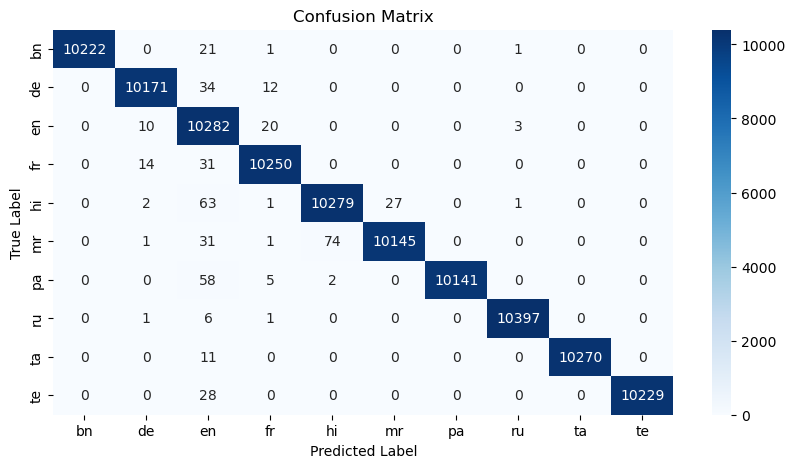

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 10. Testing the model using test cases

In [46]:
def predict_language(text):
    text_vectorized = vectorizer.transform([text])

    predicted_label = nb_model.predict(text_vectorized)[0]
    
    return predicted_label

# Example test cases
test_texts = [
    "Hello, how are you?",   # English
    "Bonjour, comment ça va?",  # French
    "नमस्ते, आप कैसे हैं?",  # Hindi
    "Wie geht es Ihnen?",  # German
    "స్వాగతం, మీరు ఎలా ఉన్నారు?", #Telgu
    "ਸਤਿ ਸ਼੍ਰੀ ਅਕਾਲ ਤੁਹਾਡਾ ਕੀ ਹਾਲ ਹੈ", #Punjabi
    "வணக்கம், எப்படி இருக்கிறீர்கள்?", #Tamil
    "कसे आहात?", #Marathi
    "হ্যালো, কেমন আছো?", #Bengali
    "меня зовут Рия" #Russian
]

for text in test_texts:
    predicted_lang = predict_language(text)
    print("Text: " + text + "\nPredicted Language: " + predicted_lang + "\n")

Text: Hello, how are you?
Predicted Language: en

Text: Bonjour, comment ça va?
Predicted Language: fr

Text: नमस्ते, आप कैसे हैं?
Predicted Language: hi

Text: Wie geht es Ihnen?
Predicted Language: de

Text: స్వాగతం, మీరు ఎలా ఉన్నారు?
Predicted Language: te

Text: ਸਤਿ ਸ਼੍ਰੀ ਅਕਾਲ ਤੁਹਾਡਾ ਕੀ ਹਾਲ ਹੈ
Predicted Language: pa

Text: வணக்கம், எப்படி இருக்கிறீர்கள்?
Predicted Language: ta

Text: कसे आहात?
Predicted Language: mr

Text: হ্যালো, কেমন আছো?
Predicted Language: bn

Text: меня зовут Рия
Predicted Language: ru

